# Supervised Machine Learning Project 
## Asset Maintenance use-case for a Synthetic Railway Company
#### 27.04.2022

</br>


### Data Set Information:

- Asset dataset - This is data that describes the asset
- Asset repairs - This details the repairs of assets
- Asset replacements - This is a list of times when assets have been replaced (failed)
- Planned maintenance - This describes if the reapir or replacement 
- Additional asset attributes - This gives additional infomation about assets

### References:
- [1] https://towardsdatascience.com/how-to-implement-machine-learning-for-predictive-maintenance-4633cdbe4860
- [2] https://medium.com/swlh/machine-learning-for-equipment-failure-prediction-and-predictive-maintenance-pm-e72b1ce42da1
- [3] https://www.infoq.com/articles/machine-learning-techniques-predictive-maintenance/

In [104]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
# dataset files location
folder_path = './SyntheticData'

In [59]:
# get all files
files = os.listdir(folder_path)
print(files)

# organize all files in a dictionary of dataframes
df_dict = {}
filenames = []
for file in files: 
    filenames.append(file[:-4])  # slice .csv extension from name
    df_dict[file[:-4]] = pd.read_csv(folder_path + '/' + file)    

['asset_attribute_data_general.csv', 'asset_attribute_data_usage.csv', 'asset_attribute_data_weather.csv', 'asset_data.csv', 'planned_data.csv', 'repair_data.csv', 'replacement_data.csv']


# 1. Getting familiar with the data

In [60]:
df_dict['asset_attribute_data_general'].head()

,asset_id,asset_install_team,asset_line,asset_material
0,A:cpjwvv,team4,east_line,iron
1,A:xoauw0,team3,south_line,steel
2,A:xpqps2,team1,east_line,iron
3,A:m44bmt,team4,west_line,steel
4,A:rwkyh1,team2,north_line,steel


In [61]:
df_dict['asset_attribute_data_usage'].head()

,asset_id,asset_trains_per_hour
0,A:cpjwvv,2.0
1,A:xoauw0,4.0
2,A:xpqps2,4.0
3,A:m44bmt,4.0
4,A:rwkyh1,1.0


In [62]:
df_dict['asset_attribute_data_weather'].head()

,asset_id,asset_weather_cluster
0,A:cpjwvv,standard
1,A:xoauw0,standard
2,A:xpqps2,sun
3,A:m44bmt,sun
4,A:rwkyh1,standard


In [63]:
df_dict['asset_data'].head()

,asset_id,end_date,latitude,longitude,previous_repairs,previous_unplanned,start_date
0,A:cpjwvv,2012-02-26,51.108966,-1.382032,0,0,2008-06-26
1,A:xoauw0,2005-03-01,58.369692,-4.982743,0,0,2003-06-08
2,A:xpqps2,2009-10-27,55.759249,-4.593591,0,0,2007-03-03
3,A:m44bmt,2008-02-23,52.289685,-1.418834,0,0,2007-01-17
4,A:rwkyh1,2013-06-21,55.686979,-4.542553,0,0,2012-06-03


The previous/above tables all share an identification column that could be used to merge them: <b> asset_id </b>

In [64]:
df_dict['planned_data'].head()

,asset_id,event_date,event_id,planned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,False
1,A:cpjwvv,2008-08-30,E:trj6ixh0o9,False
2,A:cpjwvv,2009-02-06,E:y5bjtvl55l,False
3,A:cpjwvv,2010-02-07,E:evsbi3vj21,False
4,A:cpjwvv,2010-02-17,E:njcddphr3b,False


In [65]:
df_dict['repair_data'].head()

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1


In [66]:
df_dict['replacement_data'].head()

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned
0,A:cpjwvv,2008-08-30,E:trj6ixh0o9,2008-06-26,0,0
1,A:cpjwvv,2009-02-06,E:y5bjtvl55l,2008-08-30,0,0
2,A:cpjwvv,2010-02-07,E:evsbi3vj21,2009-02-06,0,0
3,A:cpjwvv,2010-02-17,E:njcddphr3b,2010-02-07,0,0
4,A:cpjwvv,2010-05-18,E:fry99yixfk,2010-02-17,0,0


### Some text here...

In [67]:
# Check datasets size
for name in filenames:
    print(name, df_dict[name].shape)

asset_attribute_data_general (200, 4)
asset_attribute_data_usage (200, 2)
asset_attribute_data_weather (200, 2)
asset_data (200, 7)
planned_data (2032, 4)
repair_data (859, 6)
replacement_data (1173, 6)


* More repairs than replacements, means unbalanced data regarding type of event
* 200 assets, 2032 events, distributed by repairs and replacements (859+1173=2032)

## 2. Building features datasets 
Merging, droping, cleaning, etc

In [68]:
df_assets = pd.merge(df_dict['asset_attribute_data_general'], df_dict['asset_attribute_data_usage'], on='asset_id')
df_assets = pd.merge(df_assets, df_dict['asset_attribute_data_weather'], on='asset_id')

In [69]:
df_assets

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster
0,A:cpjwvv,team4,east_line,iron,2.0,standard
1,A:xoauw0,team3,south_line,steel,4.0,standard
2,A:xpqps2,team1,east_line,iron,4.0,sun
3,A:m44bmt,team4,west_line,steel,4.0,sun
4,A:rwkyh1,team2,north_line,steel,1.0,standard
...,...,...,...,...,...,...
195,A:271d3q,team4,south_line,iron,4.0,standard
196,A:6tjk91,team3,west_line,iron,4.0,standard
197,A:j9z5oa,team2,east_line,iron,8.0,heavy_rain
198,A:100egl,team2,west_line,alloy,2.0,sun


In [70]:
df_assets = pd.merge(df_assets, df_dict['asset_data'], on='asset_id')

In [71]:
df_assets

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,end_date,latitude,longitude,previous_repairs,previous_unplanned,start_date
0,A:cpjwvv,team4,east_line,iron,2.0,standard,2012-02-26,51.108966,-1.382032,0,0,2008-06-26
1,A:xoauw0,team3,south_line,steel,4.0,standard,2005-03-01,58.369692,-4.982743,0,0,2003-06-08
2,A:xpqps2,team1,east_line,iron,4.0,sun,2009-10-27,55.759249,-4.593591,0,0,2007-03-03
3,A:m44bmt,team4,west_line,steel,4.0,sun,2008-02-23,52.289685,-1.418834,0,0,2007-01-17
4,A:rwkyh1,team2,north_line,steel,1.0,standard,2013-06-21,55.686979,-4.542553,0,0,2012-06-03
...,...,...,...,...,...,...,...,...,...,...,...,...
195,A:271d3q,team4,south_line,iron,4.0,standard,2012-05-12,52.883360,-2.048643,0,0,2005-10-15
196,A:6tjk91,team3,west_line,iron,4.0,standard,2016-07-08,54.765397,-2.104487,0,0,2013-08-22
197,A:j9z5oa,team2,east_line,iron,8.0,heavy_rain,2017-06-01,54.332715,-2.370033,0,0,2013-05-21
198,A:100egl,team2,west_line,alloy,2.0,sun,2013-08-18,54.151059,-2.068212,0,0,2008-05-04


In [72]:
# Remove latitude and longitude features. Realy hard to work with coordinates.
df_assets = df_assets.drop(['latitude', 'longitude'], axis=1)

In [73]:
# Just organizing the columns
def move_col(name, pos):
    column = df_assets.pop(name)
    df_assets.insert(pos, name, column)
    
move_col('start_date', 1)
move_col('end_date', 2)

In [74]:
df_assets

,asset_id,start_date,end_date,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,previous_repairs,previous_unplanned
0,A:cpjwvv,2008-06-26,2012-02-26,team4,east_line,iron,2.0,standard,0,0
1,A:xoauw0,2003-06-08,2005-03-01,team3,south_line,steel,4.0,standard,0,0
2,A:xpqps2,2007-03-03,2009-10-27,team1,east_line,iron,4.0,sun,0,0
3,A:m44bmt,2007-01-17,2008-02-23,team4,west_line,steel,4.0,sun,0,0
4,A:rwkyh1,2012-06-03,2013-06-21,team2,north_line,steel,1.0,standard,0,0
...,...,...,...,...,...,...,...,...,...,...
195,A:271d3q,2005-10-15,2012-05-12,team4,south_line,iron,4.0,standard,0,0
196,A:6tjk91,2013-08-22,2016-07-08,team3,west_line,iron,4.0,standard,0,0
197,A:j9z5oa,2013-05-21,2017-06-01,team2,east_line,iron,8.0,heavy_rain,0,0
198,A:100egl,2008-05-04,2013-08-18,team2,west_line,alloy,2.0,sun,0,0


### Merging with the dataset including event_id feature

In [75]:
df_repairs = pd.merge(
    df_dict['repair_data'], 
    df_dict['replacement_data'], 
    on=['asset_id', 'event_id', 'event_date', 'installed_date', 'previous_repairs', 'previous_unplanned'], 
    how='outer')

In [76]:
df_repairs

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1
...,...,...,...,...,...,...
2027,A:bo36ea,2008-03-11,E:tiimfa24q1,2007-12-13,0,0
2028,A:bo36ea,2008-06-08,E:o7x8b82wrs,2008-05-26,0,0
2029,A:bo36ea,2008-06-08,E:urquo998rq,2008-06-08,0,0
2030,A:bo36ea,2008-12-12,E:cxh6sozhrx,2008-06-08,0,0


In [77]:
df_repairs = pd.merge(
    df_repairs, 
    df_dict['planned_data'], 
    on=['asset_id', 'event_id', 'event_date'])

In [78]:
df_repairs

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,planned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1,False
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1,False
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2,False
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1,False
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1,False
...,...,...,...,...,...,...,...
2027,A:bo36ea,2008-03-11,E:tiimfa24q1,2007-12-13,0,0,False
2028,A:bo36ea,2008-06-08,E:o7x8b82wrs,2008-05-26,0,0,False
2029,A:bo36ea,2008-06-08,E:urquo998rq,2008-06-08,0,0,True
2030,A:bo36ea,2008-12-12,E:cxh6sozhrx,2008-06-08,0,0,False


In [132]:
# set date vars to datetime type
df_repairs['event_date'] = pd.to_datetime(df_repairs['event_date'], format='%Y-%m-%d', errors='ignore')
df_repairs['installed_date'] = pd.to_datetime(df_repairs['installed_date'], format='%Y-%m-%d', errors='ignore')

Going to create new feature: <b> RUL </b> (Remaining useful life), represents days between next asset event and in our dataset its the difference between installed_date and event_date

In [134]:
df_repairs['RUL'] = (df_repairs['event_date'] - df_repairs['installed_date']).dt.days
# remove features that are not going to be used
df_repairs = df_repairs.drop(['event_id', 'previous_repairs', 'previous_unplanned', 'planned'], axis=1)
# order by dates
df_repairs = df_repairs.sort_values(by='installed_date')

In [135]:
df_repairs

,asset_id,event_date,installed_date,RUL
327,A:hhuqjc,2000-03-02,2000-01-06,56
496,A:g387mk,2000-05-07,2000-01-27,101
1018,A:u65cz7,2000-02-26,2000-02-15,11
725,A:5j07tf,2001-10-07,2000-02-17,598
1019,A:u65cz7,2000-08-11,2000-02-26,167
...,...,...,...,...
1473,A:ii3vcg,2017-05-01,2017-02-27,63
1931,A:tzbon5,2017-05-11,2017-03-04,68
1972,A:4f0kgt,2017-04-02,2017-03-27,6
666,A:9ks73c,2017-05-02,2017-04-05,27


#### Comparing assets info with repairements/replacements

In [79]:
df_repairs.loc[df_repairs['asset_id'] == 'A:cpjwvv', :]

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,planned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1,False
859,A:cpjwvv,2008-08-30,E:trj6ixh0o9,2008-06-26,0,0,False
860,A:cpjwvv,2009-02-06,E:y5bjtvl55l,2008-08-30,0,0,False
861,A:cpjwvv,2010-02-07,E:evsbi3vj21,2009-02-06,0,0,False
862,A:cpjwvv,2010-02-17,E:njcddphr3b,2010-02-07,0,0,False
863,A:cpjwvv,2010-05-18,E:fry99yixfk,2010-02-17,0,0,False
864,A:cpjwvv,2010-06-03,E:eku0zyi4cd,2010-05-18,0,0,False
865,A:cpjwvv,2010-08-06,E:sv5orf2kc2,2010-06-03,0,0,False
866,A:cpjwvv,2010-09-01,E:giwnv8wxjw,2010-08-06,0,0,False
867,A:cpjwvv,2010-12-19,E:a8iikd6tuj,2010-09-01,0,0,False


In [80]:
df_assets.loc[df_assets['asset_id'] == 'A:cpjwvv', :]

,asset_id,start_date,end_date,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,previous_repairs,previous_unplanned
0,A:cpjwvv,2008-06-26,2012-02-26,team4,east_line,iron,2.0,standard,0,0


* Start date corresponds to the earlier date of the installed date;
* When there is an event, the date will count as the installed date for next event
* What is the end date used for?

In [81]:
df_repairs.loc[df_repairs['asset_id'] == 'A:m44bmt', :]

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,planned
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1,False
5,A:m44bmt,2008-01-22,E:og70gj9mu2,2007-11-07,1,1,False
877,A:m44bmt,2007-03-26,E:f7vew1qt43,2007-01-17,0,0,False
878,A:m44bmt,2007-10-08,E:6bdckn1ae6,2007-03-29,0,0,False
879,A:m44bmt,2007-11-07,E:2woc3z6iqu,2007-10-08,0,0,False


In [82]:
df_assets.loc[df_assets['asset_id'] == 'A:m44bmt', :]

,asset_id,start_date,end_date,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,previous_repairs,previous_unplanned
3,A:m44bmt,2007-01-17,2008-02-23,team4,west_line,steel,4.0,sun,0,0


In [83]:
df_repairs['planned'].value_counts()

False    1743
True      289
Name: planned, dtype: int64

A fazer:
* verificar os NaN
* verificar datas duplicadas

In [84]:
df_repairs.loc[df_repairs['asset_id'] == 'A:xoauw0', :]

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,planned
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1,False
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2,False
871,A:xoauw0,2003-07-26,E:s08alqo9vd,2003-06-08,0,0,False
872,A:xoauw0,2003-08-28,E:ws1vyy7oao,2003-07-26,0,0,False
873,A:xoauw0,2005-01-18,E:uxv1ak7npw,2004-10-18,0,0,False
874,A:xoauw0,2005-02-09,E:3ijuweltm9,2005-01-18,0,0,False


## When will the assets break down?

In [85]:
df_assets.loc[df_assets['asset_id'] == 'A:xoauw0', :]

,asset_id,start_date,end_date,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,previous_repairs,previous_unplanned
1,A:xoauw0,2003-06-08,2005-03-01,team3,south_line,steel,4.0,standard,0,0


In [126]:
# testing first approach
df_example = df_repairs
df_example = df_example.loc[df_example['asset_id'] == 'A:cpjwvv', :]
df_example['event_date'] = pd.to_datetime(df_example['event_date'], format='%Y-%m-%d', errors='ignore')
df_example['installed_date'] = pd.to_datetime(df_example['installed_date'], format='%Y-%m-%d', errors='ignore')

# RUL: Remaining useful life
df_example['RUL'] = (df_example['event_date'] - df_example['installed_date']).dt.days
df_example = df_example.drop(['event_id', 'previous_repairs', 'previous_unplanned', 'planned'], axis=1)
df_example = df_example.sort_values(by='installed_date')
df_example

c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,asset_id,event_date,installed_date,RUL
859,A:cpjwvv,2008-08-30,2008-06-26,65
860,A:cpjwvv,2009-02-06,2008-08-30,160
861,A:cpjwvv,2010-02-07,2009-02-06,366
862,A:cpjwvv,2010-02-17,2010-02-07,10
863,A:cpjwvv,2010-05-18,2010-02-17,90
864,A:cpjwvv,2010-06-03,2010-05-18,16
865,A:cpjwvv,2010-08-06,2010-06-03,64
866,A:cpjwvv,2010-09-01,2010-08-06,26
867,A:cpjwvv,2010-12-19,2010-09-01,109
868,A:cpjwvv,2011-03-25,2010-12-19,96


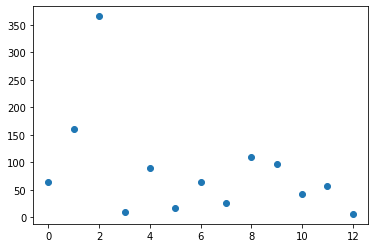

In [127]:
ey = df_example['RUL']
ex = np.arange(0, len(ey))
plt.scatter(ex, ey)

# Apply regression to this data 

In [128]:
# np.array(ey)

In [129]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error

# # create linear regression model
# # define the most basic linear algebra equation y = ax + b

# def linear_eq(a, x, b):
#     return a * x + b

# m = LinearRegression()
# m.fit(ex.reshape(-1, 1), ey)
# a = m.coef_[0][0]
# b = m.intercept_[0]

# line = linear_eq(a, ex, b)

In [130]:
# visualize the points and model

# plt.close('all')

# plt.scatter(ex, ey)
# plt.plot(ex, line, lw=2)

# plt.title('a = {a}\nb = {b}'.format(a=a, b=b))
# plt.show()

## Why are the assets breaking down? 
## What are the main causes for the assets to break down?
Approach to understand why assets are breaking down according to environmental features and trying to predict its causes in order to act in a preventive manner

In [140]:
target = df_repairs['RUL']
target

327      56
496     101
1018     11
725     598
1019    167
       ... 
1473     63
1931     68
1972      6
666      27
1903     23
Name: RUL, Length: 2032, dtype: int64

In [131]:
df_repairs

,asset_id,start_date,end_date,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,previous_repairs,previous_unplanned
0,A:cpjwvv,2008-06-26,2012-02-26,team4,east_line,iron,2.0,standard,0,0
1,A:xoauw0,2003-06-08,2005-03-01,team3,south_line,steel,4.0,standard,0,0
2,A:xpqps2,2007-03-03,2009-10-27,team1,east_line,iron,4.0,sun,0,0
3,A:m44bmt,2007-01-17,2008-02-23,team4,west_line,steel,4.0,sun,0,0
4,A:rwkyh1,2012-06-03,2013-06-21,team2,north_line,steel,1.0,standard,0,0
...,...,...,...,...,...,...,...,...,...,...
195,A:271d3q,2005-10-15,2012-05-12,team4,south_line,iron,4.0,standard,0,0
196,A:6tjk91,2013-08-22,2016-07-08,team3,west_line,iron,4.0,standard,0,0
197,A:j9z5oa,2013-05-21,2017-06-01,team2,east_line,iron,8.0,heavy_rain,0,0
198,A:100egl,2008-05-04,2013-08-18,team2,west_line,alloy,2.0,sun,0,0


Para esta abordagem, vou considerar o target como o tempo de vida do asset em dias, pois assim vou tentar avaliar quanto tempo de vida terá um asset de acordo com as caracteristicas envolventes que lhe são atribuidas. No entanto, outra abordagem que serviria de experimental seria utilizar como target a feature de RUL, ou até mesmo o total de nr de eventos